In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, pareto
import scipy.stats as stats

## Task 1: Simulate values for given distributions

### Exponential

In [2]:
def simulate_exponential(n, lam):
    U = np.random.uniform(size=n)
    X = -np.log(U) / lam
    return X

In [3]:
# 10 000 samples w rate 2
samples_exp = simulate_exponential(10000, lam=2)

Histogram of samples against analytical results

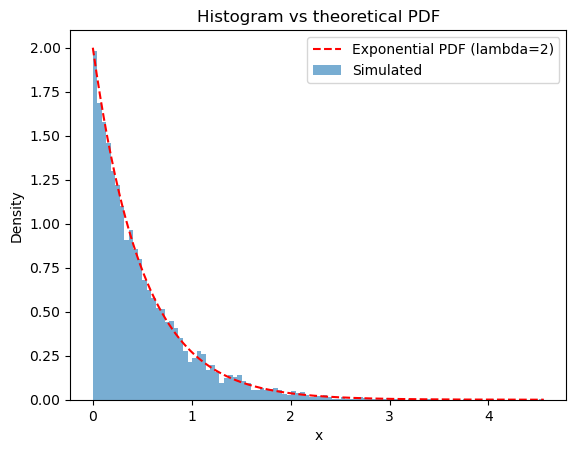

In [4]:
# plot histogram
plt.hist(samples_exp, bins=100, density=True, alpha=0.6, label='Simulated')
# overlay theoretical PDF
x = np.linspace(0, np.max(samples_exp), 500)
pdf = 2 * np.exp(-2 * x) 
plt.plot(x, pdf, 'r--', label='Exponential PDF (lambda=2)')
plt.title('Histogram vs theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()


Kolmogorov–Smirnov test (should check if we have to implement ourselves or if we can use built in?)

In [5]:
# test against the exponential distribution with scale = 1/lambda
D_stat, p_value = kstest(samples_exp, 'expon', args=(0, 1/2))

print(f"K-S test statistic: {D_stat:.4f}")
print(f"P-value: {p_value:.4f}")

K-S test statistic: 0.0070
P-value: 0.7130


### Normal

In [6]:
def simulate_normal_box_muller(n, mu=0, sigma=1):
    U1 = np.random.uniform(size=n//2)
    U2 = np.random.uniform(size=n//2)

    R = np.sqrt(-2 * np.log(U1))
    theta = 2 * np.pi * U2

    Z1 = R * np.cos(theta)
    Z2 = R * np.sin(theta)

    Z = np.concatenate([Z1, Z2])
    return Z 

In [7]:
samples_normal = simulate_normal_box_muller(10000)

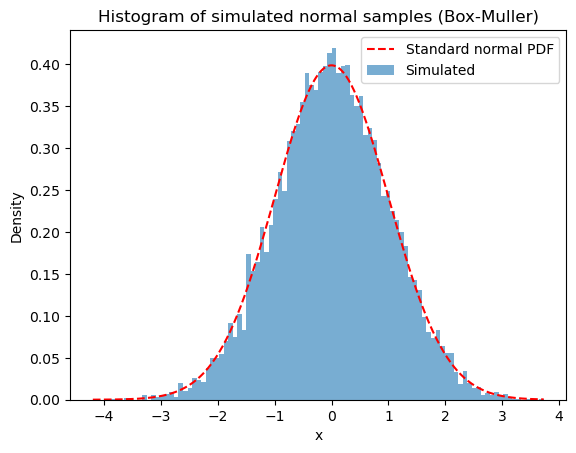

In [8]:
plt.hist(samples_normal, bins=100, density=True, alpha=0.6, label="Simulated")
x = np.linspace(min(samples_normal), max(samples_normal), 500)
pdf = norm.pdf(x)  # Standard normal
plt.plot(x, pdf, 'r--', label='Standard normal PDF')
plt.title("Histogram of simulated normal samples (Box-Muller)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

Kolmogorov–Smirnov test

In [9]:
D_stat, p_value = kstest(samples_normal, 'norm') 
print(f"K-S test statistic: {D_stat:.4f}")
print(f"P-value: {p_value:.4f}")

K-S test statistic: 0.0085
P-value: 0.4612


### Pareto

In [10]:
def simulate_pareto(n, beta=1, k=2.5):
    U = np.random.uniform(size=n)
    X = beta * (1 / U)**(1 / k)
    return X

In [11]:
# parameters
n = 10000
beta = 1
k_values = [2.05, 2.5, 3, 4]

samples_dict = {}
for k in k_values:
    samples_dict[k] = simulate_pareto(n, beta=beta, k=k)

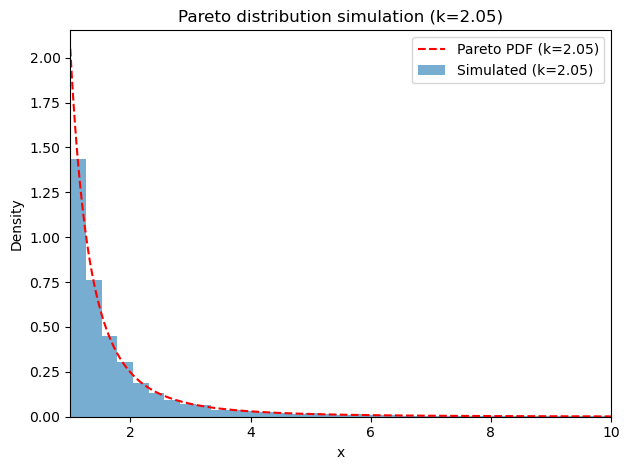

Kolmogorov-Smirnov test for k = 2.05
  K-S statistic: 0.0065
  P-value:       0.7869



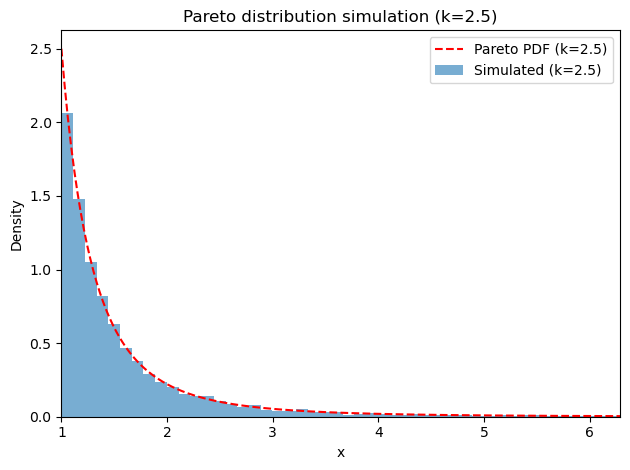

Kolmogorov-Smirnov test for k = 2.5
  K-S statistic: 0.0047
  P-value:       0.9804



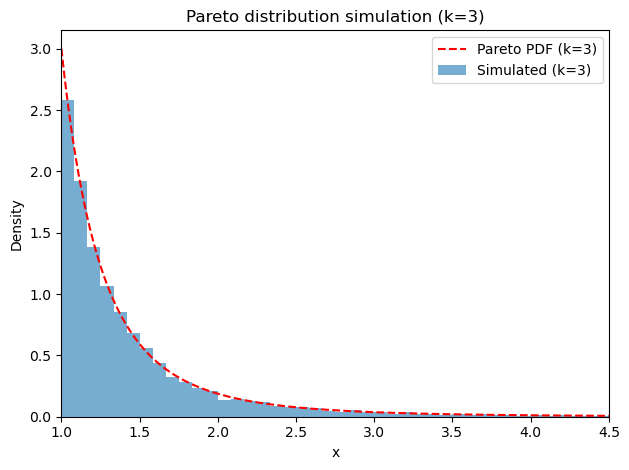

Kolmogorov-Smirnov test for k = 3
  K-S statistic: 0.0080
  P-value:       0.5412



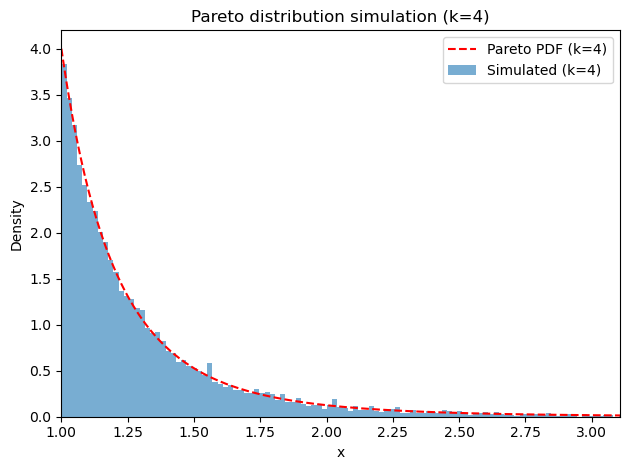

Kolmogorov-Smirnov test for k = 4
  K-S statistic: 0.0063
  P-value:       0.8270



In [12]:
for k in k_values:
    samples = samples_dict[k]
    plt.hist(samples, bins=500, density=True, alpha=0.6, label=f"Simulated (k={k})")
    
    # theoretical PDF
    x = np.linspace(beta, np.percentile(samples, 99.5), 500)
    pdf = pareto.pdf(x, b=k, scale=beta)  # scipys pareto uses shape=b and scale=beta
    plt.plot(x, pdf, 'r--', label=f"Pareto PDF (k={k})")    
    plt.title(f"Pareto distribution simulation (k={k})")
    plt.xlabel("x")
    plt.xlim(left=1, right=np.percentile(samples, 99))
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Kolmogorov–Smirnov test
    D_stat, p_value = kstest(samples, 'pareto', args=(k, 0, beta))
    print(f"Kolmogorov-Smirnov test for k = {k}")
    print(f"  K-S statistic: {D_stat:.4f}")
    print(f"  P-value:       {p_value:.4f}\n")

## Task 2: Comparison of analytical and empirical mean of Pareto

In [13]:
results = []

for k in k_values:
    samples = samples_dict[k]   
    empirical_mean = np.mean(samples)
    empirical_var = np.var(samples)
    
    # theoretical values
    analytical_mean = beta * k / (k - 1) if k > 1 else np.inf
    analytical_var = (beta**2 * k) / ((k - 1)**2 * (k - 2)) if k > 2 else np.inf
    
    results.append({
        "k": k,
        "Empirical mean": empirical_mean,
        "Analytical mean": analytical_mean,
        "Empirical var": empirical_var,
        "Analytical var": analytical_var
    })

print(f"{'k':<6}{'Empirical mean':<20}{'Analytical mean':<20}{'Empirical var':<20}{'Analytical var':<20}")
for res in results:
    print(f"{res['k']:<6.2f}{res['Empirical mean']:<20.4f}{res['Analytical mean']:<20.4f}{res['Empirical var']:<20.4f}{res['Analytical var']:<20.4f}")


k     Empirical mean      Analytical mean     Empirical var       Analytical var      
2.05  1.9941              1.9524              8.6538              37.1882             
2.50  1.6714              1.6667              1.9015              2.2222              
3.00  1.4937              1.5000              0.8140              0.7500              
4.00  1.3312              1.3333              0.2042              0.2222              


## Task 3: Normal 95% confidence interval

In [39]:
# parameters
mu_true = 0
sigma_true = 1
sample_size = 10
num_intervals = 100

mean_covers = 0
var_covers = 0

mean_cis = []
var_cis = []

for _ in range(num_intervals):
    sample = simulate_normal_box_muller(sample_size, mu=mu_true, sigma=sigma_true)
    
    x_bar = np.mean(sample)
    s2 = np.var(sample, ddof=1) # N-1 for sample variance
    
    # 95% CI for mean using t-distribution
    t_crit = stats.t.ppf(0.975, df=sample_size-1)
    ci_mean_lower = x_bar - t_crit * np.sqrt(s2/sample_size)
    ci_mean_upper = x_bar + t_crit * np.sqrt(s2/sample_size)
    mean_cis.append((ci_mean_lower, ci_mean_upper))
    
    if ci_mean_lower <= mu_true <= ci_mean_upper:
        mean_covers += 1

    # 95% CI for variance using chi-square distribution
    chi2_high = stats.chi2.ppf(0.975, df=sample_size-1)  
    chi2_low = stats.chi2.ppf(0.025, df=sample_size-1) 
    ci_var_lower = (sample_size - 1) * s2 / chi2_high
    ci_var_upper = (sample_size - 1) * s2 / chi2_low
    var_cis.append((ci_var_lower, ci_var_upper))
    
    if ci_var_lower <= sigma_true**2 <= ci_var_upper:
        var_covers += 1


Proportion of mean CIs containing true mean: 0.96
Proportion of variance CIs containing true variance: 0.93


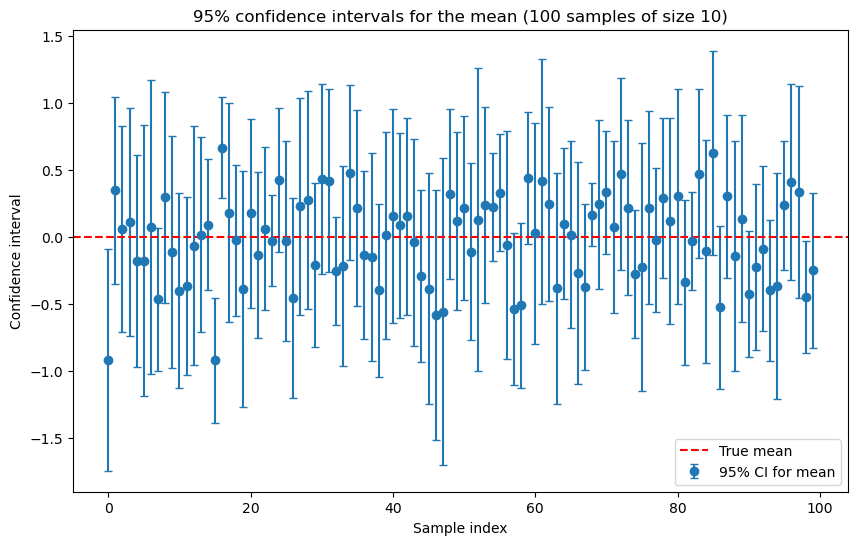

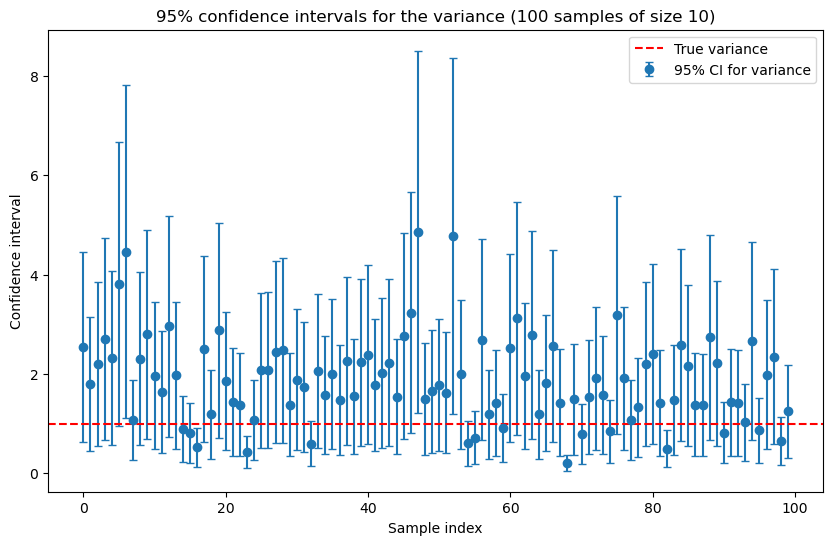

In [42]:
print(f"Proportion of mean CIs containing true mean: {mean_covers / num_intervals:.2f}")
print(f"Proportion of variance CIs containing true variance: {var_covers / num_intervals:.2f}")

# plotting the confidence intervals for the mean
mean_cis = np.array(mean_cis)
ci_centers = (mean_cis[:, 0] + mean_cis[:, 1]) / 2
ci_errors = (mean_cis[:, 1] - mean_cis[:, 0]) / 2

plt.figure(figsize=(10, 6))
plt.errorbar(range(num_intervals), ci_centers, yerr=ci_errors, fmt='o', capsize=3, label='95% CI for mean')
plt.axhline(mu_true, color='red', linestyle='--', label='True mean')
plt.xlabel('Sample index')
plt.ylabel('Confidence interval')
plt.title('95% confidence intervals for the mean (100 samples of size 10)')
plt.legend()
plt.show()

# plotting the confidence intervals for the variance
var_cis = np.array(var_cis)
ci_centers = (var_cis[:, 0] + var_cis[:, 1]) / 2
ci_errors = (var_cis[:, 1] - var_cis[:, 0]) / 2

plt.figure(figsize=(10, 6))
plt.errorbar(range(num_intervals), ci_centers, yerr=ci_errors, fmt='o', capsize=3, label='95% CI for variance')
plt.axhline(sigma_true**2, color='red', linestyle='--', label='True variance')
plt.xlabel('Sample index')
plt.ylabel('Confidence interval')
plt.title('95% confidence intervals for the variance (100 samples of size 10)')
plt.legend()
plt.show()


## Task 4: Pareto distribution w Composition

In [16]:
def simulate_pareto_composition_mu(n, mu=1):
    # simulate Y \sim Exponential(mu)
    U_Y = np.random.uniform(size=n)
    Y = -np.log(U_Y) / mu
    
    # simulate X | Y \sim Exponential(rate=Y)
    U_X = np.random.uniform(size=n)
    X = -np.log(U_X) / Y  
    
    return X

In [17]:
n = 10000 
mu = 1

samples = simulate_pareto_composition_mu(n, mu)

print("Sample mean:", samples.mean())
print("Sample max:", samples.max())
print("Sample min:", samples.min())
print("Median:", np.median(samples))

Sample mean: 27.011789171362413
Sample max: 197387.05205440256
Sample min: 7.32884887973465e-06
Median: 1.0111314201511488


k = 1, so mean and variance is inf